# Diffusion2D Python Bindings

In this notebook, demonstrate the useage of the Diffuson2D solver. At this time, the only supported use is with the provided Python bindings. In the future, I will develop a solver that accepts input text files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Import the bindings
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'bin'))

In [2]:
from Diffusion2D import Mesh, BoundaryConditions, Diffusion2D

## Test Problem

In [3]:
# Mesh Dimensions
Lx = Ly = 1.0
Nx = Ny = 100

# Boundary Condition Types: 0 = Dirichlet, 1 = Neumann
# Conditions are specified like [type, value]
N = [0, 1]
S = [0, 0]
E = [0, 1]
W = [0, 0]

### Solve Steady State

We can solve the steady state problem with a function call. Uses `Eigen`'s sparse Conjugate Gradient linear solver.

In [4]:
# Simulation Objects
problem_name = 'Laplace1'
mesh = Mesh(Lx, Ly, Nx, Ny)
bounds = BoundaryConditions()
bounds.addBC('N', *N)
bounds.addBC('S', *S)
bounds.addBC('E', *E)
bounds.addBC('W', *W)
problem = Diffusion2D(mesh, bounds, 0.0, problem_name)

In [5]:
problem.solveSteady()

In [6]:
XX, YY = np.meshgrid(
    np.linspace(0.0, Lx, Nx),
    np.linspace(Ly, 0.0, Ny)
, indexing='xy')

Text(0, 0.5, 'Y')

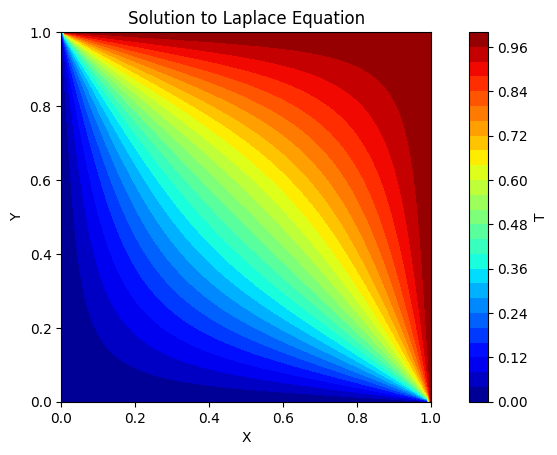

In [7]:
cont = plt.contourf(XX, YY, problem.solField, cmap='jet', levels=30)
clb = plt.colorbar(cont)
clb.set_label('T')
plt.axis('square')
plt.title('Solution to Laplace Equation')
plt.xlabel('X')
plt.ylabel('Y')

### Solve Transient Problem

The transient solution currently requires that we specify an initial guess.

In [8]:
# Simulation Objects
problem_name = 'Laplace2'
mesh = Mesh(Lx, Ly, Nx, Ny)
bounds = BoundaryConditions()
bounds.addBC('N', *N)
bounds.addBC('S', *S)
bounds.addBC('E', *E)
bounds.addBC('W', *W)
problem = Diffusion2D(mesh, bounds, 0.0, problem_name)

In [9]:
x = np.zeros(mesh.Nunk, dtype=np.float64) # Our initial guess is the same size a the number of interior cells in the mesh

# Unsteady call takes: initial guess, final time, timestep (0 means auto-determine with CFL), output frequency, and convergence tolerance (negaive means no convergence checking) 
problem.solveUnsteady(x, 100.0, 0, 0.001, 1e-10)

The results of the transient simulation are stored in the "Laplace2" folder.

### Transient with UDFs

UDFs are defined using valid Lua code. You can either pass in a Lua function as a string, or you can give it the path of a lua script. <br>
The UDF function can only depend on one variable. UDFs are JIT compiled and are pretty performant.
Say that we want to simulate a sine wave boundary on the west side of the domain:

Text(0.5, 1.0, 'UDF Example')

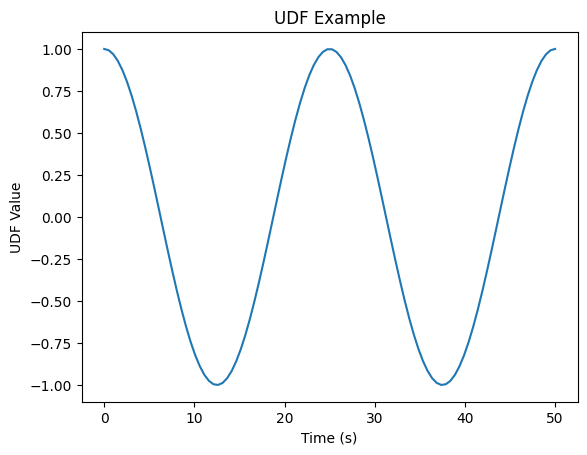

In [5]:
tFinal = 50.0 # Final time for the simuation
RPT = 2 # Number of cylces in the simulation
w = (2*np.pi*RPT)/tFinal
t = np.linspace(0.0, 50.0, 100)
y = np.cos(w*t)
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('UDF Value')
plt.title('UDF Example')

Lua has been allowed access to the open libraries. We specify our UDF like below:

In [5]:
with open('udf1.lua') as f:
    print(f.read())
f.close()

function example_udf(t)
        return math.cos(0.25132*t)
    end


In [6]:
# Simulation Objects
# Here, the difference is the overloaded function call for "addBC"
# Boundary Condition types for this call: 2 - Dirichlet UDF, 3 - Neumann UDF
# The full call is addBC(face, type, funcName, UDF(path or string))
N = [0, 0]
S = [0, 0]
E = [0, 0]

problem_name = 'udfExample'
mesh = Mesh(Lx, Ly, Nx, Ny)
bounds = BoundaryConditions()
bounds.addBC('N', *N)
bounds.addBC('S', *S)
bounds.addBC('E', *E)
bounds.addBC('W', 2, "example_udf", "udf1.lua")
problem = Diffusion2D(mesh, bounds, 0.0, problem_name)

In [8]:
x = np.zeros(mesh.Nunk, dtype=np.float64)
problem.solveUnsteady(x, tFinal, 0, 0.1, -1)

### Example of a Custom Initial Condition

In [5]:
from PIL import Image, ImageDraw, ImageFont

In [6]:
def render_text_on_array(ZZ, text, font_path='arial.ttf', font_size=None):
    # Create an image from the ZZ array
    image = Image.fromarray(np.uint8(ZZ))
    draw = ImageDraw.Draw(image)

    # Set font size relative to the image size if not specified
    if font_size is None:
        font_size = int(image.height * 0.5 / len(text.split('\n')))  # Half the vertical space per line

    # Load a font
    font = ImageFont.truetype(font_path, font_size)

    # Calculate text size and position
    text_width, text_height = draw.textsize(text, font=font)
    position = ((image.width - text_width) / 2, (image.height - text_height) / 2)

    # Draw text onto the image
    draw.text(position, text, fill=1, font=font)

    # Convert back to an array and return
    return np.array(image)

#### Diffusion 2D Initial Condition

In [19]:
# Simulation Objects
problem_name = 'Text'
n = 200
N = [0, 0]
S = [0, 0]
E = [0, 0]
W = [0, 0]
mesh = Mesh(10.0, 10.0, n, n)
bounds = BoundaryConditions()
bounds.addBC('N', *N)
bounds.addBC('S', *S)
bounds.addBC('E', *E)
bounds.addBC('W', *W)
problem = Diffusion2D(mesh, bounds, 0.0, problem_name)

In [20]:
image = render_text_on_array(np.zeros_like(problem.solField), "Diffusion2D", font_size=35)

C:\Users\bjorn\AppData\Local\Temp\ipykernel_16744\620157746.py:14: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


We will use this text as our initial condition for the simulation.

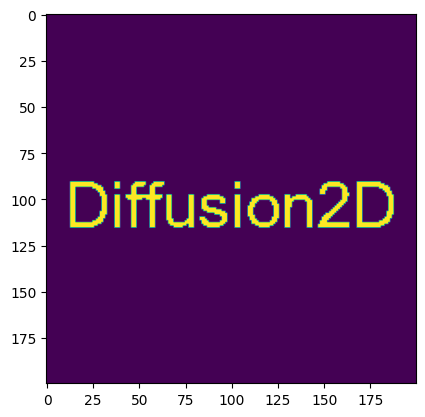

In [21]:
plt.imshow(image)

In [22]:
xi = image[1:-1, 1:-1].flatten().astype(np.float64)

In [23]:
problem.solveUnsteady(xi, 0.055, 0, 2.7e-5, 1e-3)